# Probability Classes

In `GammaBayes` there are two base classes that store models: `DiscreteLogLikelihood` and `DiscreteLogPrior`.

## `DiscreteLogLikelihood`

`DiscreteLogLikelihood` is a class that is meant to store log-likelihood functions and information when event values are assumed to be discrete. The main method it is used within the current package is with the use of another class, `IRF_LogLikelihood` which stores observation likelihoods currently for the CTA telescope.

### Inputs
    name (list[str] | tuple[str], optional): Identifier name(s) for the likelihood instance.

    pointing_direction (list, optional): Pointing direction of the telescope in galactic 
    coordinates (e.g. Directly pointing at the Galactic Centre is the default). Defaults to [0,0].

    zenith (int, optional): Zenith angle of the telescope (can be 20, 40 or 60 degrees). 
    Defaults to 20.

    hemisphere (str, optional): Which hemisphere the telescope observation was in, can be 'South' 
    or 'North'. Defaults to 'South'.

    prod_vers (int, optional): Version of the likelihood function, can currently be 3/3b or 5. 
    Defaults to 5.
    
    axes (list[np.ndarray] | tuple[np.ndarray]): Arrays defining the reconstructed observation value axes.
    
    dependent_axes (list[np.ndarray]): Arrays defining the true observation value axes.
    
    inputunit (str | list[str] | tuple[str], optional): Unit(s) of the input axes.
    
    axes_names (list[str] | tuple[str], optional): Names of the independent variable axes.
    
    dependent_axes_names (list[str] | tuple[str], optional): Names of the dependent variable axes.
    
    iterative_logspace_integrator (callable, optional): Integration method used for normalization.
    
    parameters (dict | ParameterSet, optional): Parameters for the log likelihood function.

### Examples

Let's create an instance to explain some of the functionality.

In [1]:
import random
random.seed(24) # Fixing the seed so the results are always the same

import numpy as np
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
from gammabayes.utils.config_utils import (
    read_config_file, 
    create_true_axes_from_config, 
    create_recon_axes_from_config, 
)
from matplotlib import pyplot as plt

# Has a higher resolution with more restricted axes for sake of demonstration
    # then would be feasilble to run the analysis currently
config_file_path = 'ConfigFiles/LikelihoodClass_config.yaml'
config_dict = read_config_file(config_file_path)


energy_true_axis,  longitudeaxistrue, latitudeaxistrue       = create_true_axes_from_config(config_dict)
energy_recon_axis, longitudeaxis,     latitudeaxis           = create_recon_axes_from_config(config_dict)

################################################
################################################
# Important bit
irf_loglike = IRF_LogLikelihood(
    axes            =   [energy_recon_axis,    longitudeaxis,     latitudeaxis], 
    dependent_axes  =   [energy_true_axis,     longitudeaxistrue, latitudeaxistrue],
    prod_vers='5')

################################################
################################################


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


file path: ConfigFiles/LikelihoodClass_config.yaml
0.6 2.0 200 0.03 -0.25 0.25 -0.25 0.25
0.6 2.0 200 0.03 -0.25 0.25 -0.25 0.25

Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


### Callable

So the most basic thing you can do with this class is use it as a function to represent the response of a telescope to a gamma ray event. e.g. If a gamma ray event has a true energy 1 TeV and true galactic coordinates of 0 degrees longitude and 0 degrees latitude (GC) we can look at the probabilities of what the CTA will reconstruct the event to be.

In [2]:
import numpy as np

true_energy     = 1.
true_longitude  = 0.
true_latitude   = 0.

recon_energy_mesh, recon_lon_mesh, recon_lat_mesh, \
    true_energy_mesh, true_longitude_mesh, true_latitude_mesh\
        = np.meshgrid(
            energy_recon_axis, 
            longitudeaxis, 
            latitudeaxis, 
            true_energy,
            true_longitude,
            true_latitude,
            indexing='ij')

log_probability_density_matrix = irf_loglike(
    recon_energy    = recon_energy_mesh.flatten(),
    recon_lon       = recon_lon_mesh.flatten(),
    recon_lat       = recon_lat_mesh.flatten(),
    true_energy     = true_energy_mesh.flatten(),
    true_lon        = true_longitude_mesh.flatten(),
    true_lat        = true_latitude_mesh.flatten(),
).reshape(recon_energy_mesh.shape[:3])

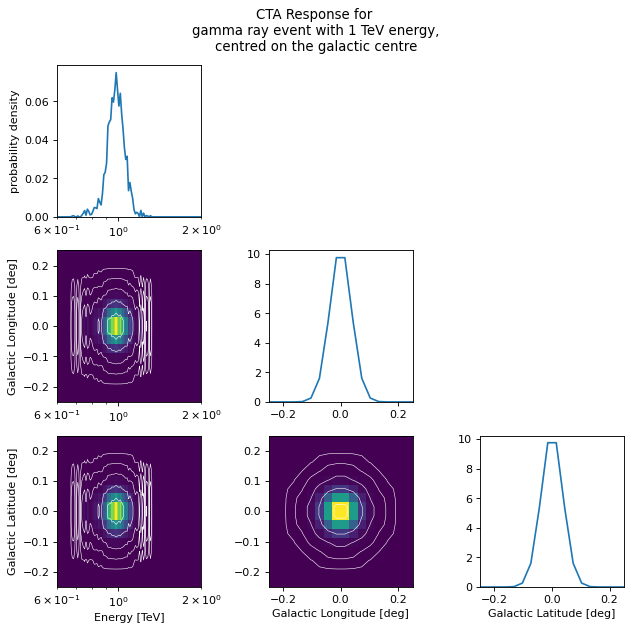

In [3]:
from gammabayes.utils.plotting import logdensity_matrix_plot
from matplotlib import pyplot as plt
fig, axs = logdensity_matrix_plot(
    axes = [energy_recon_axis, longitudeaxis, latitudeaxis],
    log_dist_matrix=log_probability_density_matrix,
    single_dim_ylabel='probability density',
    axes_scale=['log', 'linear', 'linear'],
    axis_names=['Energy [TeV]', 'Galactic Longitude [deg]', 'Galactic Latitude [deg]'],
    contours2d=True, plot_density=True, sigmalines_1d=False,
    figsize=(8,8),
    dpi=80,
)
plt.suptitle('''CTA Response for 
gamma ray event with 1 TeV energy,
centred on the galactic centre''')
plt.tight_layout()
plt.show()


### Raw Sample

If you give the likelihood a set of true values like the above you can also sample the likelihood with Inverse Transform Sampling.

In [4]:
likelihood_samples = irf_loglike.raw_sample(
    dependentvalues=[true_energy, 
                     true_longitude,
                     true_latitude],
                     numsamples=1e5)

(<Figure size 1000x400 with 3 Axes>,
 array([<Axes: xlabel='Energy [TeV]', ylabel='Events'>,
        <Axes: xlabel='Galactic Longitude [deg]', ylabel='Galactic Latitude [deg]'>],
       dtype=object))

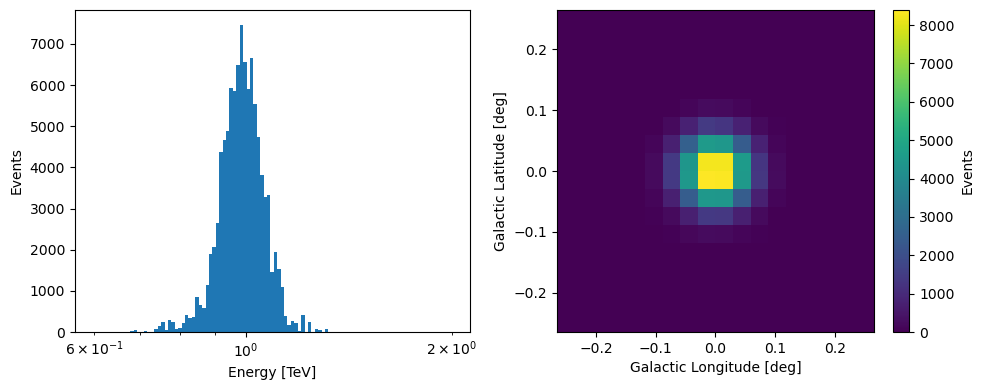

In [5]:
likelihood_samples.peek(scale='linear')

This should closely mimic the probability densities shown above. (Specifically upper to left, bottom row centre column)

### Sample

Typically we don't sample the likelihood 10^5 times for a single set of dependent values, but once every entry in a set of dependent values. This can be done via the `sample` method.

E.G. If we sample some true values with a prior, then add noise to them by sampling the likelihood for every event. (More details in the `Simulations` tutorial).



In [6]:

from gammabayes.priors import HESSCatalogueSources_Prior

hess_sources_prior = HESSCatalogueSources_Prior(
    energy_axis=energy_true_axis, 
    longitudeaxis=longitudeaxistrue, 
    latitudeaxis=latitudeaxistrue,
    irf=irf_loglike)

hess_source_catalogue_sim_events = hess_sources_prior.sample(1e3)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:583: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')


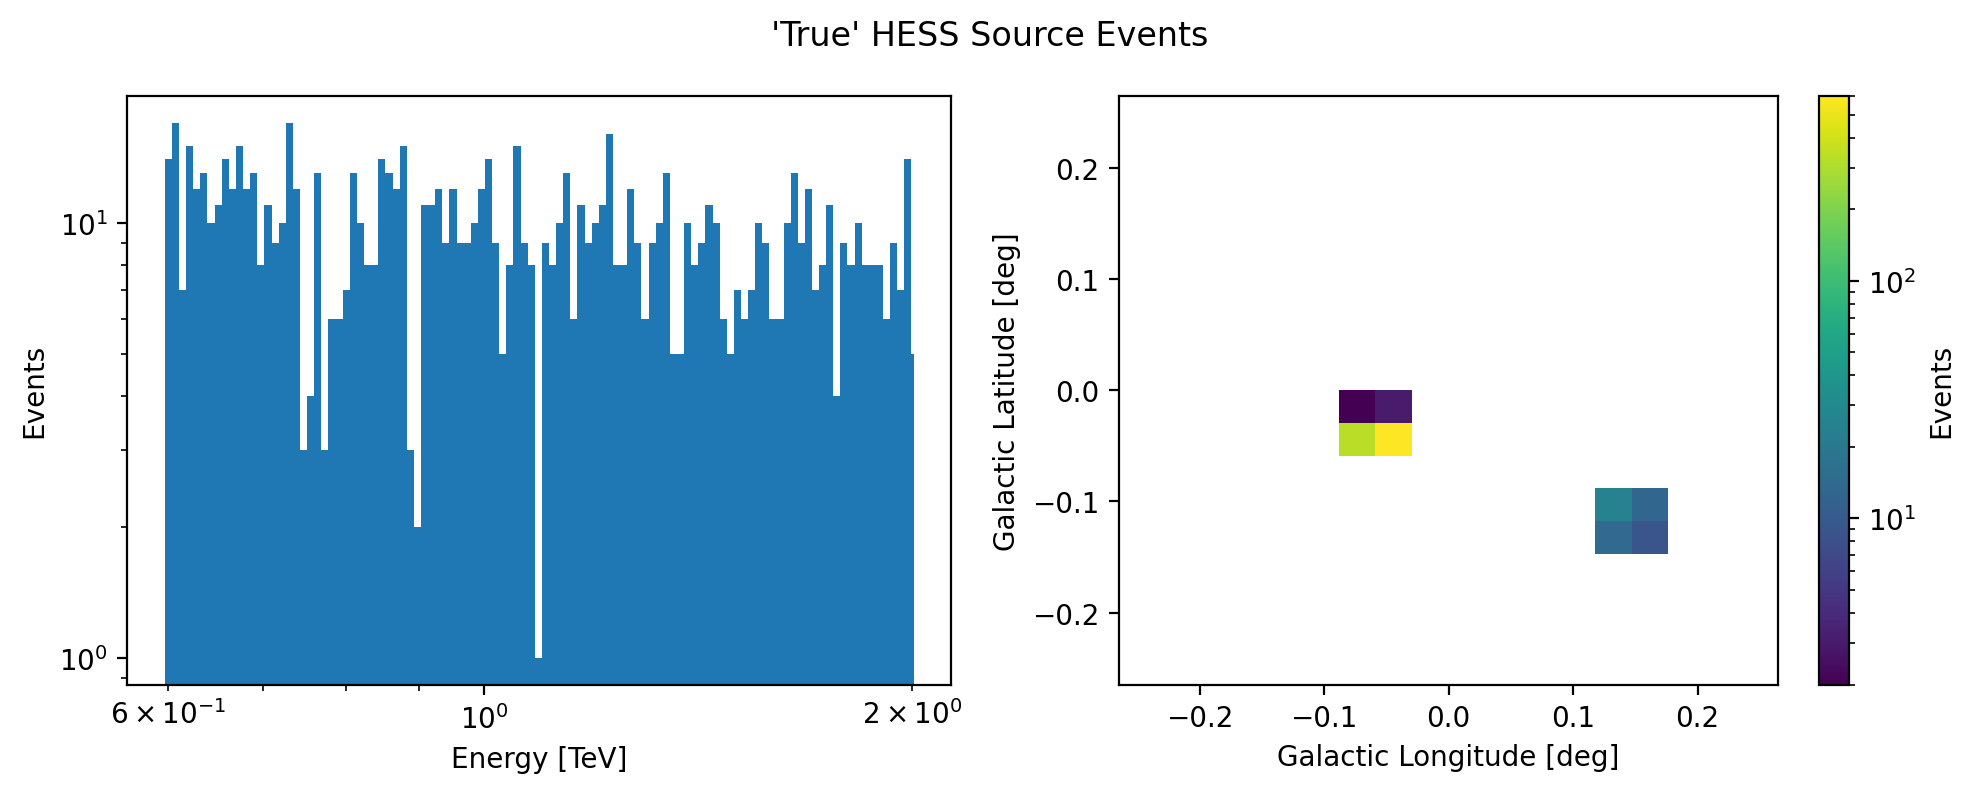

In [7]:
hess_source_catalogue_sim_events.peek(scale='log', dpi=200)
plt.suptitle("'True' HESS Source Events")
plt.tight_layout()
plt.show()

In [8]:
# This cell will take roughly 30 seconds to execute
simulated_recon_event_values = irf_loglike.sample(hess_source_catalogue_sim_events)

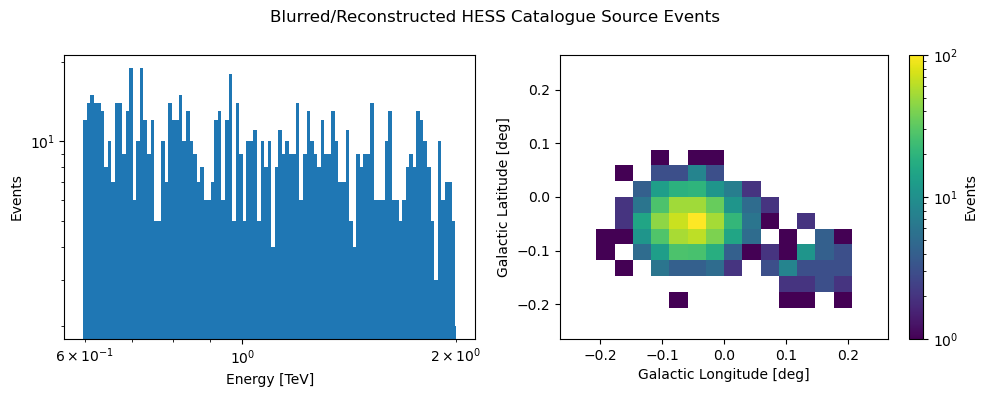

In [9]:
simulated_recon_event_values.peek(scale='log')
plt.suptitle("Blurred/Reconstructed HESS Catalogue Source Events")
plt.tight_layout()
plt.show()

So the energy distribution is very restricted, but you can clearly see how the angular coordinates of the events are blurred around the true values.

## `DiscreteLogPrior`

`DiscreteLogPrior` is a class that is meant to store log-prior functions and information when observation values are assumed to be discrete. Within this framework this class typically stores the source models, such as those within the HESS catalogue above.

### Inputs

    - name (str, optional): Name of the instance. Defaults to '[None]'.

    - inputunit (str, optional): Unit of the input values for the axes. Defaults to None.

    - logfunction (callable, optional): A function that calculates log prior values given axes values and hyperparameters.
        The function should accept arguments in the order of axis values followed by hyperparameter values.

    - log_mesh_efficient_func (callable, optional): A function for efficient computation of log prior values on a mesh grid.
        If not provided, a warning is raised about the lack of efficient computation.

    - axes (tuple[np.ndarray], optional): A tuple containing np.ndarray objects for each axis over which the prior is defined.
        Generally represents energy and sky position axes.

    - axes_names (list[str] | tuple[str], optional): Names of the axes. Defaults to ['None'].

    - default_spectral_parameters (dict, optional): Default spectral parameters for the prior. Defaults to an empty dict.

    - default_spatial_parameters (dict, optional): Default spatial parameters for the prior. Defaults to an empty dict.

    - iterative_logspace_integrator (callable, optional): Function used for integrations in log space. Defaults to iterate_logspace_integration.

Note:
- This class assumes the prior is defined in a discrete log space along specified axes.
- The axes should correspond to physical quantities over which the prior is distributed, such as energy and sky coordinates.

### Behaviours

### Callable

Just as with the `DiscreteLogLikelihood` class the `DiscreteLogPrior` class is callable/can be used as a function. An example instance of this class within the pipeline is `FermiGaggeroDiffusePrior` with represents a model for the diffuse gamma rays around the Galactic Centre.

In [10]:
from gammabayes.priors.astro_sources import FermiGaggeroDiffusePrior
diffuse_astro_prior = FermiGaggeroDiffusePrior(
    energy_axis=energy_true_axis, 
    longitudeaxis=longitudeaxistrue, 
    latitudeaxis=latitudeaxistrue, 
    inputunits=['TeV', 'deg', 'deg'],
    irf=irf_loglike)
print(diffuse_astro_prior(energy=1.0, longitude=-0.05, latitude=-0.05))
print(diffuse_astro_prior(energy=1.0, longitude=0., latitude=0.))

-3.054833742234505
-3.0284132956311374


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')


Alternatively, you can give it your own `logfunction`. e.g. A function represented the log of the estimated rate of mis-identified charged cosmic rays being detected by the CTA can be accessed though `log_bkg_CCR_dist` in the `priors` module of the package.

In [11]:
from gammabayes.priors import log_bkg_CCR_dist, DiscreteLogPrior
ccr_bkg_prior = DiscreteLogPrior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background',
                               axes=(   energy_true_axis, 
                                        longitudeaxistrue, 
                                        latitudeaxistrue,), 
                                    axes_names=['energy', 'lon', 'lat'], )

In [12]:
print(ccr_bkg_prior(1.0, 0.,0.))

4.753962316220492


### string representation

The class also has a string representation that will be shown when converting to string our calling print on an instance of the class. Showing some basic information above the logfunction that has been used (in this case a _method_ of the class itself), the names of the observation axes (pre-defined by the class) and the input units which we are (currently 15/02/24) completely optional but allow someone to more easily follow results. Currently 100% of the user-interfacing code is in units of TeV for energy and deg/galactic coordinates for sky position/angular coordinates.

In [13]:
print(diffuse_astro_prior)

Discrete log prior class
--------------------
Name: Fermi-Gaggero Diffuse Astrophysical Prior
Logfunction type: method
Input units: ['TeV', 'deg', 'deg']
Axes: ['energy', 'lon', 'lat']



### Methods

### `construct_prior_array`

For many instances within the code we want the log of the prior probability densities over a range of true values event values (energy, longitude and latitude). To aid this operation the `DiscreteLogPrior` function has the `construct_prior_array` method which produces an array of log prior probability values. 

e.g. If you don't want to have the matrix over a different set of axes than the class instance was defined with or parameters different to what the instance was defined with you can call it simply as,

In [14]:
diffuse_astro_prob_matrix = diffuse_astro_prior.construct_prior_array()

Let's just have a look at this output, it'll look a little strange due to the axes we gave it.

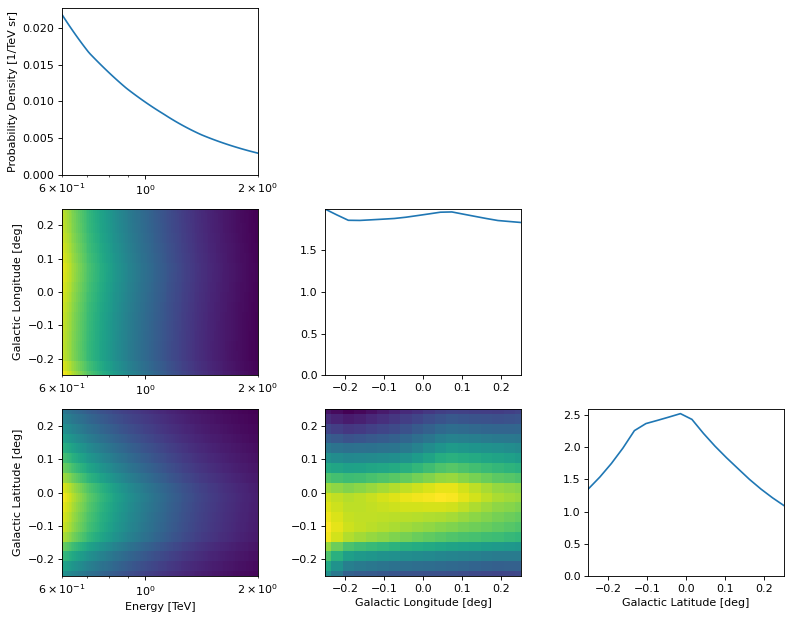

In [15]:
from gammabayes.utils.plotting import logdensity_matrix_plot

fig, axs = logdensity_matrix_plot(axes=diffuse_astro_prior.axes,
                                  log_dist_matrix=diffuse_astro_prob_matrix,
                                  axes_scale=['log', 'linear', 'linear'], 
                                  axis_names=['Energy [TeV]', 'Galactic Longitude [deg]', 'Galactic Latitude [deg]'],
                                  plot_density=True, sigmalines_1d=False, 
                                  figsize=(10,8), dpi=80, single_dim_ylabel='Probability Density [1/TeV sr]')


Here's the full docstring for this method.

    Constructs an array of log prior values over a mesh of the axes' values.

    e.g. for the mesh axis1=[0,1] and axis2=[0,2] then mesh = [ [[0,0], [0,2]], [[1,0], [1,2]] ]

    Parameters:
    - spectral_parameters (dict, optional): Spectral parameters to use. Defaults to instance's default parameters.
    
    - spatial_parameters (dict, optional): Spatial parameters to use. Defaults to instance's default parameters.
    
    - normalisation_axes (list | tuple, optional): Axes indices over which to normalise. Defaults to [0, 1, 2].
    
    - normalise (bool, optional): Whether to normalise the output array. Defaults to False.

Returns:
- np.ndarray: An array of log prior values for the specified parameters and axes.


### `normalisation`

The `normalisation` method is essentially equivalent to the `construct_prior_array` method, but integrates over the default axes given to the class to give the normalisation of the matrix. i.e. If normalised you would get 1, but we don't require the functions to be normalised, and this method allows use to normalise them within the computations.

### `sample`

As has been previously shown, one can also sample the prior to generate representative 'true' event values via Inverse Transform Sampling. i.e. If we sample the `diffuse_astro_prior` object we should be samples that look like the above probability density, but with the addition of the jacobian that accounts for the bin widths of the observations.

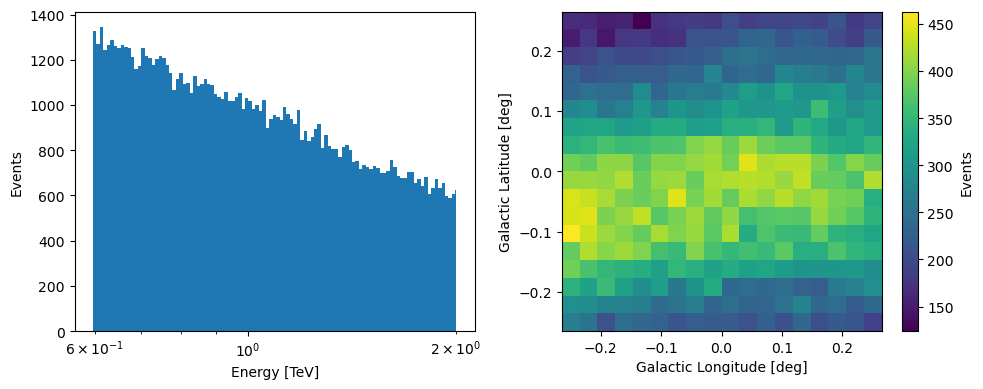

In [16]:
diffuse_astro_prior_samples = diffuse_astro_prior.sample(1e5)

diffuse_astro_prior_samples.peek(scale='linear')
plt.show()

### `save`/`load`

And as with all the (important) classes within this package there are save and load methods. The difference being that we need to save a custom function here. And generally we don't need to save a large amount of these instances at once so the save and load methods for this class just pickle and unpickle the class instance. 

In [17]:
import os
diffuse_astro_prior.save("pickled_diffuse_astro_prior.pkl")
loaded_diffuse_astro_prior = HESSCatalogueSources_Prior.load("pickled_diffuse_astro_prior.pkl")
os.system("rm -rf pickled_diffuse_astro_prior.pkl")

0

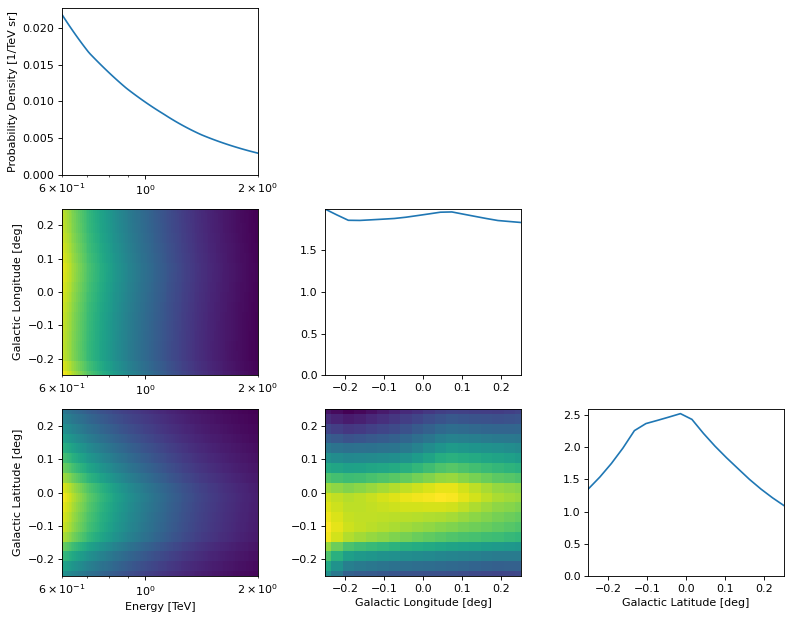

In [18]:
loaded_diffuse_astro_prob_matrix = loaded_diffuse_astro_prior.construct_prior_array()

fig, axs = logdensity_matrix_plot(axes=loaded_diffuse_astro_prior.axes,
                                  log_dist_matrix=loaded_diffuse_astro_prob_matrix,
                                  axes_scale=['log', 'linear', 'linear'], 
                                  axis_names=['Energy [TeV]', 'Galactic Longitude [deg]', 'Galactic Latitude [deg]'],
                                  plot_density=True, sigmalines_1d=False, 
                                  figsize=(10,8), dpi=80, single_dim_ylabel='Probability Density [1/TeV sr]')


## Note on `IRF_LogLikelihood` within `DiscreteLogPrior` instances

Kind of strangely, for direct astrophysical sources currently all default classes require the input of the `IRF_LogLikelihood` because they require the use of the CTA's effective area which is an Instrument Response Function (IRF), stored along with the other IRFs in the a likelihood above, but doesn't contribute to the probability distribution. 

In essence, the effective area is an IRF, but relates to the amount of events the CTA observes, not how it blurs the events seen. So to turn the prompt source flux of astrophysical sources (sky flux model) to the flux of events detected by the CTA one needs to apply the effective area.

For more information on this please refer to [this page](https://docs.gammapy.org/0.19/irf/theory.html) in the `Gammapy` documentation.